# Setup

In [1]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
import cv2
import torch
import os
import numpy as np
import random
import json
import sys
from datetime import datetime

# os.environ['CUDA_VISIBLE_DEVICES'] = "0, 1, 2, 3" # replace with the GPU IDs that are available

# to help with reproducibility
seed=0
import torch.backends.cudnn as cudnn 
random.seed(seed) 
np.random.seed(seed) 
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)   
cudnn.benchmark, cudnn.deterministic = False, True
                                        
np.set_printoptions(precision=9)

sys.path.append('../') # workaround for lack of relative import in notebooks
from sam_predictor import predictor_utils, astro_sam #, residualAttentionBlock
from losses import metrics_utils
from dataset import dataset_utils

In [2]:
kfold_iter=0

device_id=1
batch_size=8
lr=3e-5
wd=0.0005
wandb_track=True
torch.cuda.set_device(device_id)
datetime_now = datetime.now()

if wandb_track:
    # !pip install wandb
    # !wandb login
    import wandb
    wandb.login()
    run = wandb.init(project="yolo-sam", name=f"yolo-sam {datetime_now}")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: iuliaelisa15. Use `wandb login --relogin` to force relogin


In [3]:
yolo_dataset_path = '../data/xami_dataset_YOLO/' # replace with the path to the YOLO dataset

In [4]:
import yaml

with open(yolo_dataset_path+f"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dictionary with keys 'names', 'nc', 'train', 'val'

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print(classes)

coco_data_path = f'../data/xami_dataset/'
annotations_file = '_annotations.coco.json'

with open(coco_data_path+'train/'+annotations_file, 'r') as f1, open(coco_data_path+'valid/'+annotations_file, 'r') as f2:
    train_coco_data = json.load(f1)
    valid_coco_data = json.load(f2)

{0: 'central-ring', 1: 'other', 2: 'read-out-streak', 3: 'smoke-ring', 4: 'star-loop'}


In [5]:
train_dir = yolo_dataset_path+f'train/images/'
valid_dir = yolo_dataset_path+f'valid/images/'

train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

# Model setup

In [6]:
import sys
sys.path.append(os.path.join(os.getcwd(), '..', 'mobile_sam'))
from mobile_sam import sam_model_registry, SamPredictor

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
mobile_sam_checkpoint = './weights/sam_weights/sam_0_best.pth'

yolov8_pretrained_model = YOLO(f'./weights/yolo_weights/last.pt');
yolov8_pretrained_model.to(f'cuda:{device_id}');
mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

# # Residual Attention Block
# residual_block = residualAttentionBlock.ResidualAttentionBlock(d_model=256, n_head=8, mlp_ratio=4.0).to(device)
# residual_block.load_state_dict(torch.load('../output_sam/residual_attn_blk_2024-05-10 08:05:54.498084_best.pth'))

# for name, param in residual_block.named_parameters():
# 	param.requires_grad = True 

/workspace/raid/OM_DeepLearning/XAMI/train/../mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/XAMI/train/../mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/XAMI/train/../mobile_sam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Pleas

In [7]:
# astrosam_model = astro_sam.AstroSAM(mobile_sam_model, device, predictor)
astrosam_model = astro_sam.AstroSAM(
    mobile_sam_model, 
    device, 
    predictor, 
    use_yolo_masks=True, 
    wt_threshold=0.6, 
    wt_classes_ids = [1.0, 4.0])

In [8]:
for name, param in mobile_sam_model.named_parameters():
    if 'mask_decoder' in name: 
        param.requires_grad = True
    else:
        param.requires_grad = False
        
print(f"🚀 The model has {sum(p.numel() for p in astrosam_model.model.parameters() if p.requires_grad)} trainable parameters.")
# print(f"🚀 The residual attention block has {sum(p.numel() for p in astrosam_model.residualAttentionBlock.parameters() if p.requires_grad)} trainable parameters.\n")

# predictor_utils.check_requires_grad(astrosam_model.model)
# predictor_utils.check_requires_grad(astrosam_model.residualAttentionBlock)

🚀 The model has 4058340 trainable parameters.


In [9]:
import tqdm
from tqdm import tqdm

train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(parameters_to_optimize, lr=lr, weight_decay=wd) if len(parameters_to_optimize) > 0 else None

## Define metrics

In [10]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric_thresholds = [[0.5], [0.75], [0.5, 0.9]]

# Train

In [11]:
from collections import defaultdict

best_valid_loss = float('inf')
num_epochs = 10 
n_epochs_stop = num_epochs // 10 + 5
all_metrics = defaultdict(dict)
compute_metrics = True

In [12]:
# Intro
predictor_utils.print_training_intro(
    train_image_files, valid_image_files, device, metric_thresholds, num_epochs, 
    batch_size, lr, wd, wandb_track, mobile_sam_model, 'AdamW')

# Training loop
for epoch in range(num_epochs):

    # Train
    astrosam_model.model.train()
    
    # astrosam_model.residualAttentionBlock.train()
    train_results = astrosam_model.run_yolo_sam_epoch(
        yolov8_pretrained_model,
        phase='train',
        batch_size=batch_size, 
        image_files=train_image_files, 
        images_dir=train_dir, 
        num_batches=train_num_batches,
        optimizer=optimizer) 
    
    epoch_sam_loss_train, train_preds, train_gts = train_results[:3]
    train_gt_classes, train_pred_classes, train_all_iou_scores, train_mask_areas, _ = train_results[3:]

    # Validate
    astrosam_model.model.eval()
    # astrosam_model.residualAttentionBlock.eval()
    
    with torch.no_grad():
        valid_results = astrosam_model.run_yolo_sam_epoch(
            yolov8_pretrained_model,
            phase='val',
            batch_size=batch_size, 
            image_files=valid_image_files, 
            images_dir=valid_dir, 
            num_batches=valid_num_batches,
            optimizer=None) 

    epoch_sam_loss_val, valid_preds, valid_gts = valid_results[:3]
    valid_gt_classes, valid_pred_classes, valid_all_iou_scores, valid_mask_areas, pred_images = valid_results[3:]

    # Early stopping                                                                                
    if epoch_sam_loss_val < best_valid_loss:
        best_valid_loss = epoch_sam_loss_val
        best_model = astrosam_model.model
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping initiated.")
            early_stop = True
            break
        
    # Metrics
    if compute_metrics:
        for threshold in tqdm(metric_thresholds, desc="(Metrics) Processing thresholds", bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
            metric = MeanAveragePrecision(
            iou_type = "segm", 
            iou_thresholds = threshold, 
            max_detection_thresholds=[1, 10, 100],
            class_metrics=True,
            extended_summary=False)
            
            train_metrics = metrics_utils.mAP_metrics(metric,
            train_preds,
            train_gts, 
            train_gt_classes, 
            train_pred_classes, 
            train_all_iou_scores,
            train_mask_areas,
            show_metrics=False) 
                
            valid_metrics = metrics_utils.mAP_metrics(metric,
                    valid_preds,
                    valid_gts, 
                    valid_gt_classes, 
                    valid_pred_classes, 
                    valid_all_iou_scores,
                    valid_mask_areas,
                    show_metrics=False)
        
            all_metrics[tuple(threshold)] = {'train': train_metrics, 'valid': valid_metrics}

        # Prints
        if not wandb_track:
            wandb = None
        predictor_utils.prints_and_wandb(
            epoch, 
            epoch_sam_loss_train, 
            epoch_sam_loss_val, 
            all_metrics, 
            metric_thresholds,
            wandb)

    # Checkpoint save
    torch.save(best_model.state_dict(), f'./output_sam/yolo_sam_{epoch}.pth')

torch.save(best_model.state_dict(), f'./output_sam/yolo_sam_final.pth')

# Finish wandb run
if wandb_track:
    run.finish()

def convert_tensors(data):
    if isinstance(data, dict):
        return {key: convert_tensors(value) for key, value in data.items()}
    elif isinstance(data, torch.Tensor):
        return data.tolist() if data.ndim > 0 else data.item()
    else:
        return data
        
if compute_metrics:   
    metrics_dict = defaultdict(dict)
    metrics_dict[f'{metric_thresholds[0][0]}'] = convert_tensors(all_metrics[tuple(metric_thresholds[0])])
    metrics_dict[f'{metric_thresholds[1][0]}'] = convert_tensors(all_metrics[tuple(metric_thresholds[1])])
    metrics_dict[f'{metric_thresholds[2][0]}-{metric_thresholds[2][1]}'] = convert_tensors(all_metrics[tuple(metric_thresholds[2])])
    metrics_dict['best_epoch'] = best_epoch
    
    with open(f'metrics_{datetime_now}.json', 'w') as json_file:
        json.dump(metrics_dict, json_file, indent=4)

Model Training Configuration:
 - Training images: 791
 - Validation images: 264
 - Number of Epochs: 10
 - Batch Size: 8
 - Learning Rate: 3e-05
 - Weight Decay: 0.0005
 - Device: cuda:1
 - mAP thresholds: [[0.5], [0.75], [0.5, 0.9]]
 - Early Stopping: Stop if no improvement after 6 epochs.
 - Weights & Biases Tracking: Enabled.
 - Optimizer: AdamW.
 - Total Trainable Parameters: 4,058,340


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.78s/it]                                                                                                   


Train mAP[0.5]: 94.80000305175781. Valid mAP[0.5]: 89.5
Train mAP[0.75]: 73.19999694824219. Valid mAP[0.75]: 68.0999984741211
Train mAP[0.5, 0.9]: 56.900001525878906. Valid mAP[0.5, 0.9]: 53.0
Epoch 0. Train loss: 1.1372219
Epoch 0. Validation loss: 1.211247


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:35<00:00, 11.71s/it]                                                                                                   


Train mAP[0.5]: 95.0. Valid mAP[0.5]: 89.9000015258789
Train mAP[0.75]: 76.19999694824219. Valid mAP[0.75]: 70.5
Train mAP[0.5, 0.9]: 57.5. Valid mAP[0.5, 0.9]: 53.70000076293945
Epoch 1. Train loss: 1.1308488
Epoch 1. Validation loss: 1.2106562


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:33<00:00, 11.03s/it]                                                                                                   


Train mAP[0.5]: 94.9000015258789. Valid mAP[0.5]: 89.9000015258789
Train mAP[0.75]: 76.9000015258789. Valid mAP[0.75]: 71.30000305175781
Train mAP[0.5, 0.9]: 57.599998474121094. Valid mAP[0.5, 0.9]: 53.79999923706055
Epoch 2. Train loss: 1.1276192
Epoch 2. Validation loss: 1.2100265


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:34<00:00, 11.36s/it]                                                                                                   


Train mAP[0.5]: 94.9000015258789. Valid mAP[0.5]: 89.9000015258789
Train mAP[0.75]: 77.5999984741211. Valid mAP[0.75]: 71.69999694824219
Train mAP[0.5, 0.9]: 58.099998474121094. Valid mAP[0.5, 0.9]: 54.0
Epoch 3. Train loss: 1.1246467
Epoch 3. Validation loss: 1.21011


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:33<00:00, 11.11s/it]                                                                                                   


Train mAP[0.5]: 95.0. Valid mAP[0.5]: 90.0
Train mAP[0.75]: 78.4000015258789. Valid mAP[0.75]: 72.0999984741211
Train mAP[0.5, 0.9]: 58.400001525878906. Valid mAP[0.5, 0.9]: 54.20000076293945
Epoch 4. Train loss: 1.1225787
Epoch 4. Validation loss: 1.2099108


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:32<00:00, 10.99s/it]                                                                                                   


Train mAP[0.5]: 95.0999984741211. Valid mAP[0.5]: 90.0
Train mAP[0.75]: 78.9000015258789. Valid mAP[0.75]: 72.80000305175781
Train mAP[0.5, 0.9]: 58.70000076293945. Valid mAP[0.5, 0.9]: 54.5
Epoch 5. Train loss: 1.1207401
Epoch 5. Validation loss: 1.2102401


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:33<00:00, 11.12s/it]                                                                                                   


Train mAP[0.5]: 95.0999984741211. Valid mAP[0.5]: 90.19999694824219
Train mAP[0.75]: 79.0999984741211. Valid mAP[0.75]: 73.0999984741211
Train mAP[0.5, 0.9]: 58.900001525878906. Valid mAP[0.5, 0.9]: 54.79999923706055
Epoch 6. Train loss: 1.119473
Epoch 6. Validation loss: 1.2104669


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:33<00:00, 11.16s/it]                                                                                                   


Train mAP[0.5]: 95.0. Valid mAP[0.5]: 89.9000015258789
Train mAP[0.75]: 79.69999694824219. Valid mAP[0.75]: 73.19999694824219
Train mAP[0.5, 0.9]: 59.29999923706055. Valid mAP[0.5, 0.9]: 54.900001525878906
Epoch 7. Train loss: 1.1178524
Epoch 7. Validation loss: 1.209937


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:32<00:00, 10.99s/it]                                                                                                   


Train mAP[0.5]: 95.0999984741211. Valid mAP[0.5]: 90.4000015258789
Train mAP[0.75]: 79.69999694824219. Valid mAP[0.75]: 73.19999694824219
Train mAP[0.5, 0.9]: 59.400001525878906. Valid mAP[0.5, 0.9]: 55.20000076293945
Epoch 8. Train loss: 1.1165308
Epoch 8. Validation loss: 1.2105917


(Metrics) Processing thresholds: 100%|██████████| 3/3 [00:32<00:00, 10.88s/it]                                                                                                   


Train mAP[0.5]: 95.0999984741211. Valid mAP[0.5]: 90.30000305175781
Train mAP[0.75]: 80.0999984741211. Valid mAP[0.75]: 73.69999694824219
Train mAP[0.5, 0.9]: 59.900001525878906. Valid mAP[0.5, 0.9]: 55.400001525878906
Epoch 9. Train loss: 1.1152042
Epoch 9. Validation loss: 1.2103001


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [13]:
best_epoch

4

In [14]:
all_metrics 

defaultdict(dict,
            {(0.5,): {'train': {'map': tensor(0.9513),
               'map_50': tensor(0.9513),
               'map_75': tensor(-1.),
               'map_small': tensor(0.9098),
               'map_medium': tensor(0.9542),
               'map_large': tensor(1.),
               'mar_1': tensor(0.4827),
               'mar_10': tensor(0.9501),
               'mar_100': tensor(0.9720),
               'mar_small': tensor(0.9729),
               'mar_medium': tensor(0.9696),
               'mar_large': tensor(1.),
               'map_per_class': tensor([0.9999, 0.9282, 0.8756, 0.9755, 0.9774]),
               'mar_100_per_class': tensor([1.0000, 0.9688, 0.9165, 0.9871, 0.9875]),
               'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)},
              'valid': {'map': tensor(0.9029),
               'map_50': tensor(0.9029),
               'map_75': tensor(-1.),
               'map_small': tensor(0.8212),
               'map_medium': tensor(0.9137),
             

# Metrics visualisation

In [15]:
def ious_pred_vs_gt(gts, preds):
    all_ious_pred_vs_gt_flatten = []
    all_ious_pred_vs_gt = []
    
    for i in range(len(gts)):
        iou_image_scores = []
        for gt_mask, pred_mask in zip(gts[i], preds[i]):
            intersection = np.logical_and(gt_mask, pred_mask)
            union = np.logical_or(gt_mask, pred_mask)
            iou_score = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
            iou_image_scores.append(iou_score)
            all_ious_pred_vs_gt_flatten.append(iou_score)
        all_ious_pred_vs_gt.append(iou_image_scores)
        
    return all_ious_pred_vs_gt_flatten, all_ious_pred_vs_gt

train_all_ious_pred_vs_gt, train_ious_pred_vs_gt = ious_pred_vs_gt(train_gts, train_preds)
valid_all_ious_pred_vs_gt, valid_ious_pred_vs_gt = ious_pred_vs_gt(valid_gts, valid_preds)

In [16]:
# IoUs frequency

train_all_ious_flatten, train_mask_areas_flatten = metrics_utils.flatten_ious_areas(train_pred_classes, train_all_iou_scores, train_mask_areas)
valid_all_ious_flatten, valid_mask_areas_flatten = metrics_utils.flatten_ious_areas(valid_pred_classes, valid_all_iou_scores, valid_mask_areas)

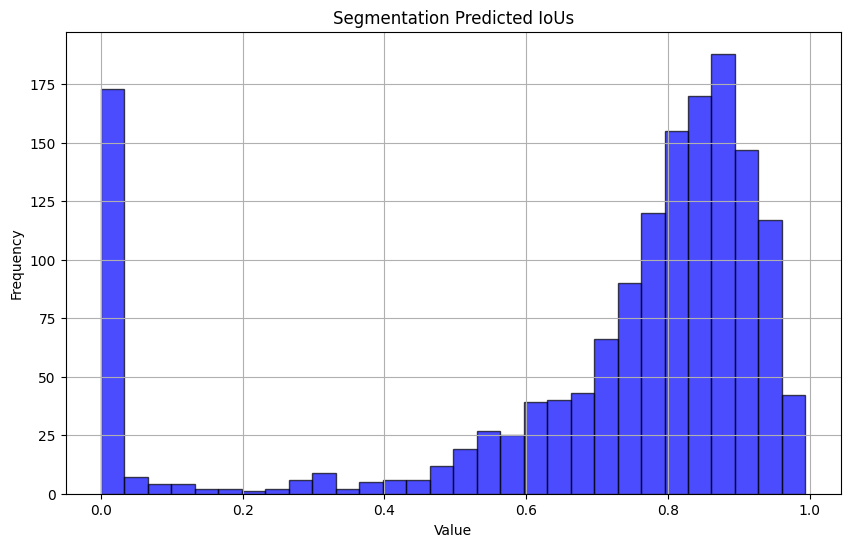

In [17]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_all_ious_pred_vs_gt, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Segmentation Predicted IoUs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

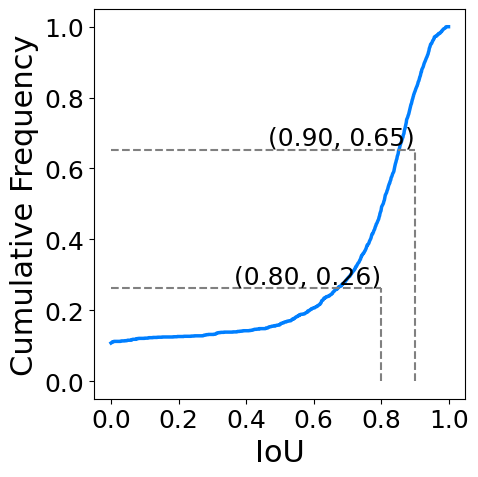

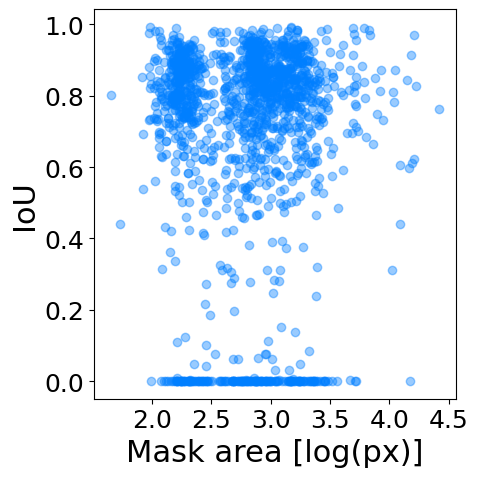

In [80]:
import numpy as np
from matplotlib import rcParams

rcParams.update({'font.size': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 14, 'font.family':'sans-serif'})

ious_train = train_all_ious_pred_vs_gt
ious_valid = valid_all_ious_pred_vs_gt
areas_train = train_mask_areas_flatten
areas_valid = valid_mask_areas_flatten

vals_train, base_train = np.histogram(ious_train, bins=1000, range=(0, 1), density=True)
cumulative_train = np.cumsum(vals_train * np.diff(base_train))
vals_valid, base_valid = np.histogram(ious_valid, bins=1000, range=(0, 1), density=True)
cumulative_valid = np.cumsum(vals_valid * np.diff(base_valid))

plt.figure(figsize=(5, 5))
# plt.plot(base_train[:-1], cumulative_train, label='Train', color='magenta')
plt.plot(base_valid[:-1], cumulative_valid, color='#007FFF', linewidth=2.5, label=None)

quartiles_y = np.quantile(cumulative_train, [0.8, 0.9])
quartiles_x = np.interp(quartiles_y, cumulative_train, base_train[:-1])

for qx, qy in zip(quartiles_x, quartiles_y):
    plt.hlines(qy, xmin=0, xmax=qx, colors='grey', linestyles='dashed')
    plt.vlines(qx, ymin=0, ymax=qy, colors='grey', linestyles='dashed')
    plt.text(qx, qy, f'({qx:.2f}, {qy:.2f})', fontsize=18, verticalalignment='bottom', horizontalalignment='right')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('IoU', fontsize=22)
plt.ylabel('Cumulative Frequency', fontsize=22)
# plt.legend(fontsize=18, loc='upper left')
plt.tight_layout()
plt.savefig('../plots/cdf_ious.png', dpi=500)
plt.show()

#D81B60
#1E88E5

#1A85FF
#D41159
plt.figure(figsize=(5, 5))
# plt.scatter(np.log10(areas_train), ious_train, alpha=0.5, label='Train', color='#D81B60')
plt.scatter(np.log10(areas_valid), ious_valid, alpha=0.4, label='Validation', color='#007FFF')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# x_ticks_positions = np.array([20000, 40000, 60000])*(np.max(np.log10(areas_train))- np.min(np.log10(areas_train)))/(np.max(areas_train)-np.min(areas_train))   # show orignal ticks but log plot
# x_ticks_labels = ['20000', '40000', '60000']

# plt.xticks(x_ticks_positions, x_ticks_labels, fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Mask area [log(px)]', fontsize=22)
plt.ylabel('IoU', fontsize=22)
# plt.legend(fontsize=18, loc='lower right', bbox_to_anchor=(1, 0.04))
plt.tight_layout()
plt.savefig('../plots/ious_and_areas_log.png', dpi=500)
plt.show()

In [19]:
np.max(areas_train), np.max(areas_valid)

(74093, 26290)

In [20]:
np.min(ious_train), np.min(ious_valid)

(0.0, 0.0)

In [21]:
np.min(ious_train), np.max(ious_train), np.min(ious_valid), np.max(ious_valid)

(0.0, 0.9986449864498645, 0.0, 0.9937694704049844)

### IoU TP FP FN plot (~29s)

In [45]:
def compute_metrics_with_range(gt_masks, pred_masks, image=None):
    """Compute the True Positive, False Positive, and False Negative BINARY masks for multiple segmentations."""
    
    combined_gt_mask = np.zeros_like(gt_masks[0][0], dtype=bool)
    combined_pred_mask = np.zeros_like(pred_masks[0], dtype=bool)
    filtered_pred_masks = np.zeros_like(pred_masks, dtype=bool)
      
    for gt_mask in gt_masks:
        combined_gt_mask = np.logical_or(combined_gt_mask, gt_mask)

    for pred_mask in pred_masks:
        combined_pred_mask = np.logical_or(combined_pred_mask, pred_mask.astype(bool))

    intersection = np.sum(np.logical_and(combined_gt_mask, combined_pred_mask))
    union = np.sum(np.logical_or(combined_gt_mask, combined_pred_mask))

    iou = intersection/union
    
    true_positive_mask = np.logical_and(combined_gt_mask, combined_pred_mask)
    false_negative_mask = np.logical_and(combined_gt_mask, np.logical_not(combined_pred_mask))
    false_positive_mask = np.logical_and(combined_pred_mask, np.logical_not(combined_gt_mask))

    return true_positive_mask, false_positive_mask, false_negative_mask, iou

Indices: [217, 92, 3, 46, 109, 158, 64, 79] Images: ['S0305800101_U_png.rf.a1b8a0fb9b71ec0b3fce7d88863a05cf.jpg', 'S0672050101_V_png.rf.c4838c7fd8fbbb8589ea27662acc8607.jpg', 'S0511001101_L_png.rf.a280de071ca2519116b24f245362daed.jpg', 'S0112910301_U_png.rf.667775238e0993f31688140f98a44713.jpg', 'S0804670601_V_png.rf.8077956f3e8869e68521f7c702ca6270.jpg', 'S0822400101_L_png.rf.09af63e0a46256785eb8e3889fe3e82a.jpg', 'S0551640201_M_png.rf.4bd561eb9d88ffd5dd9d995ca7ef6da9.jpg', 'S0653380401_M_png.rf.580d6f9aa045488fb14de956962d24b6.jpg']

Plotting...


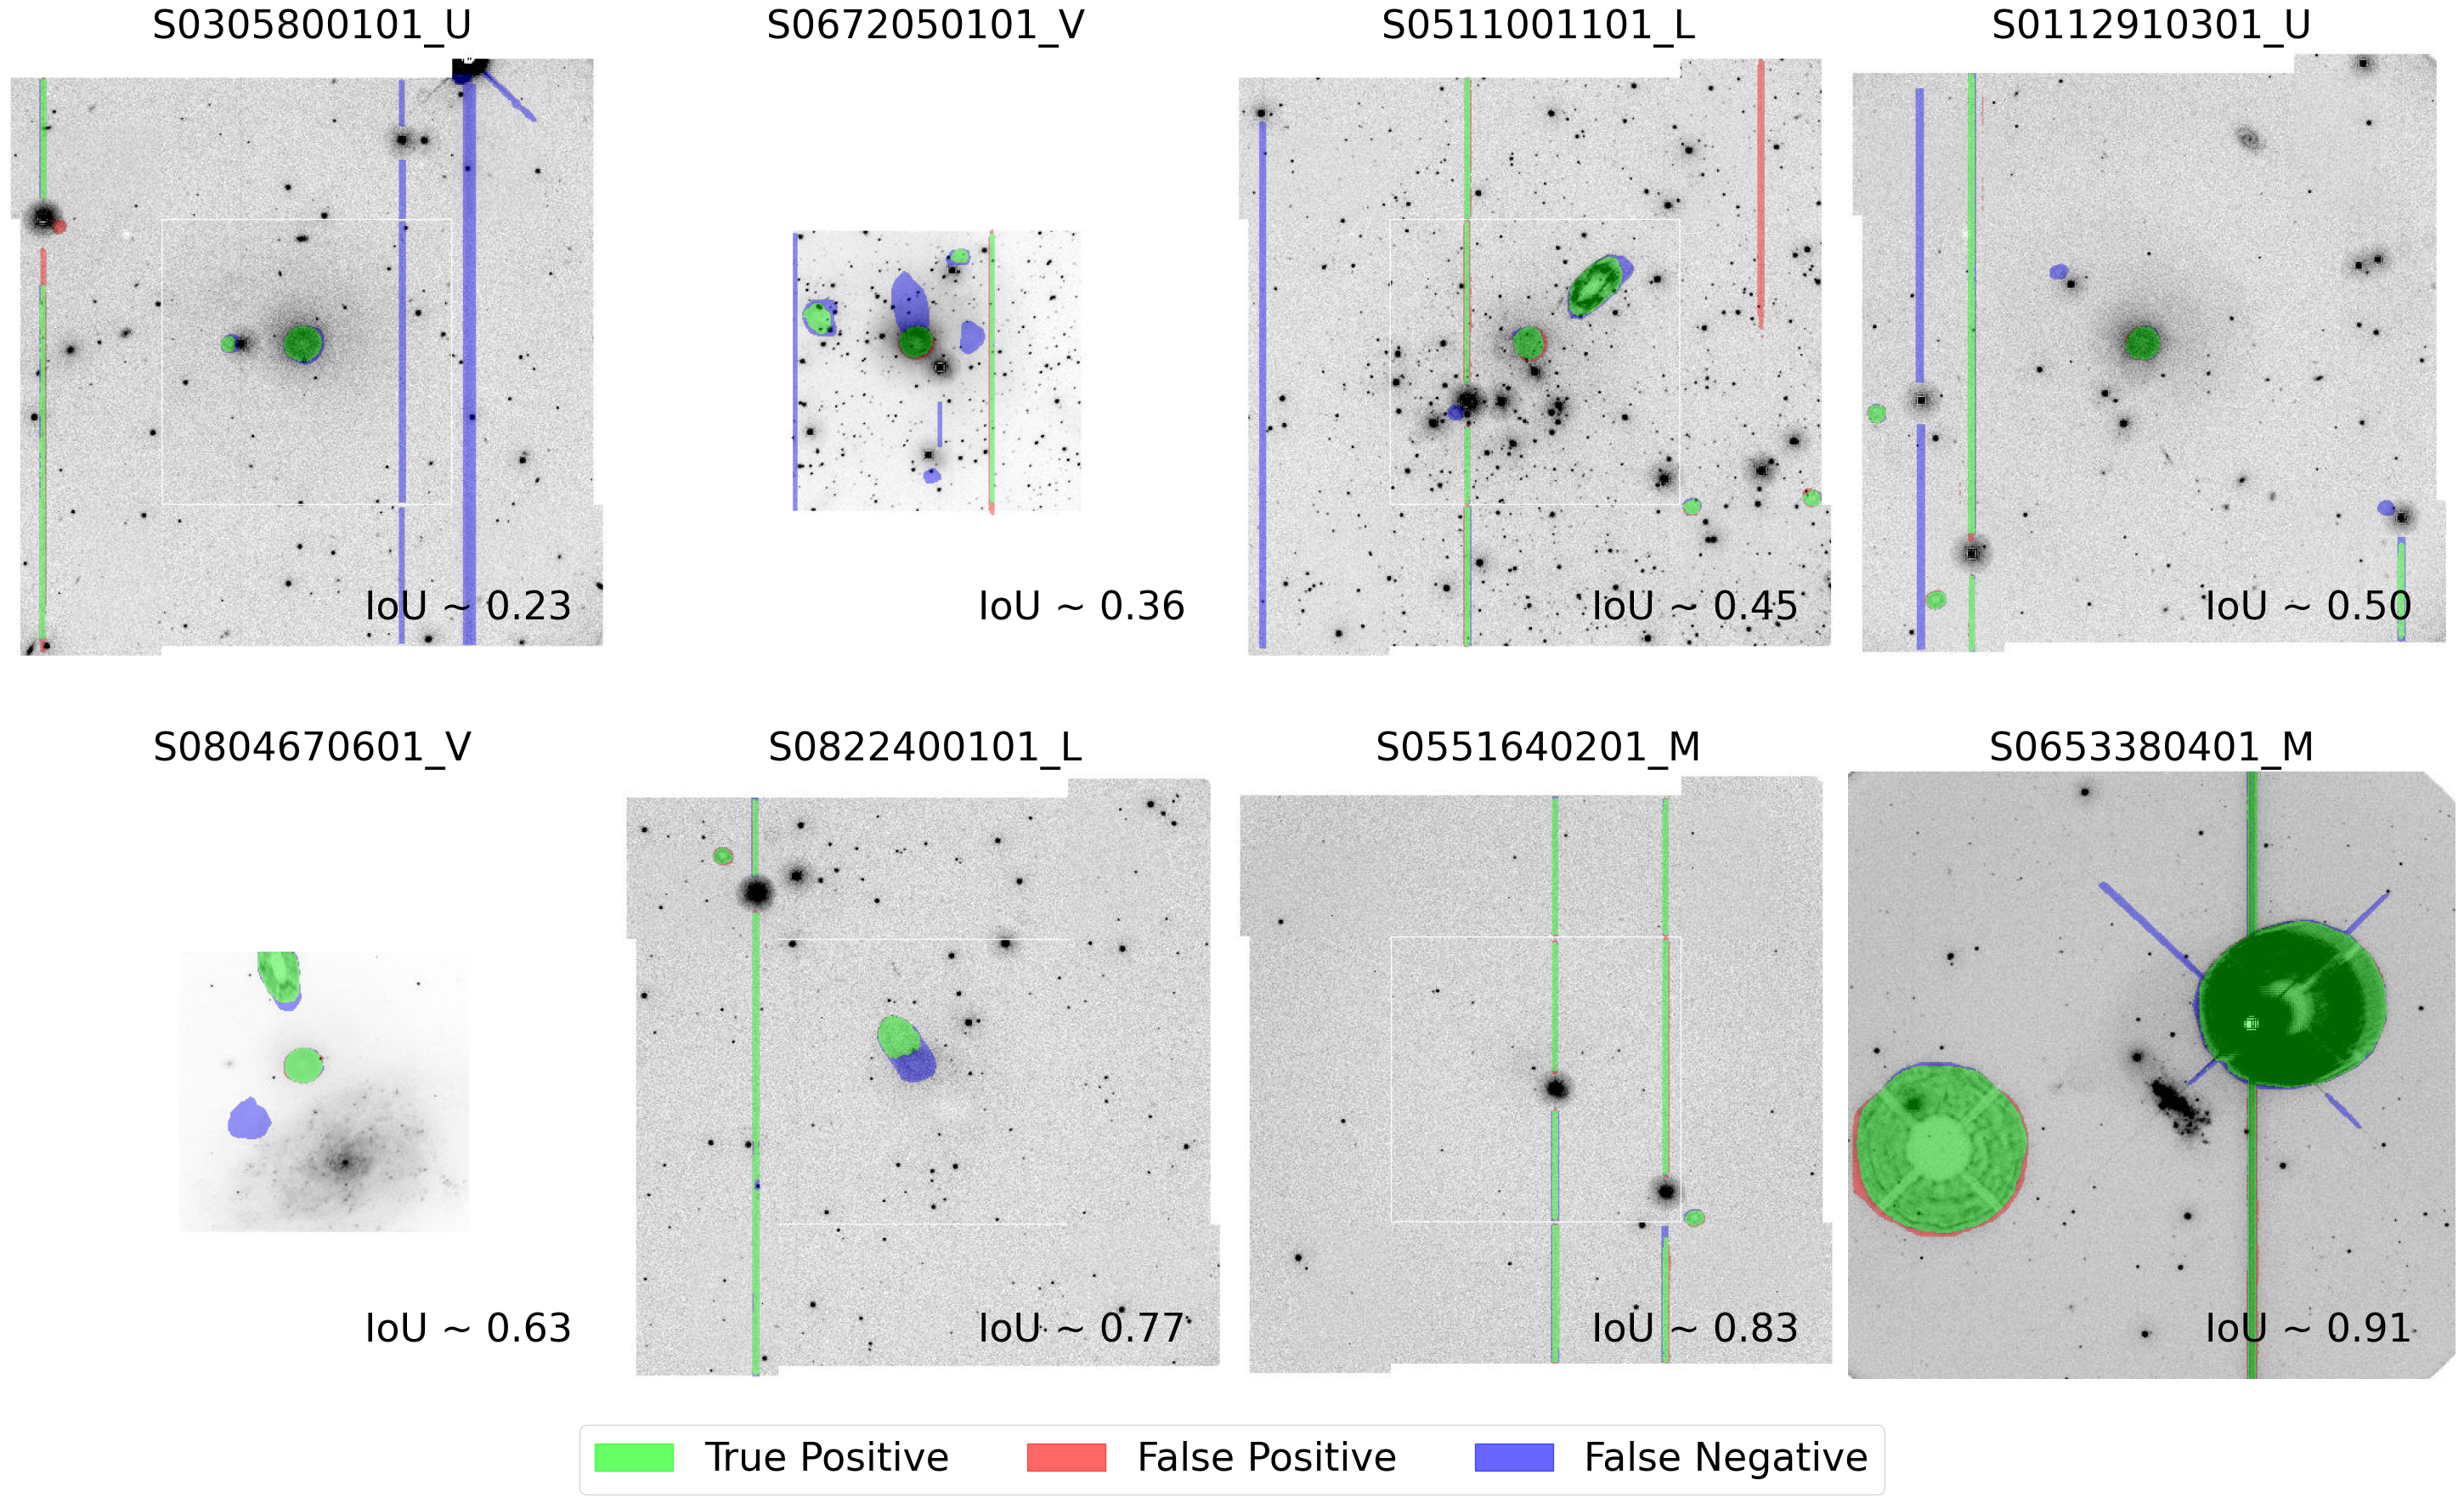

In [72]:
import random
import matplotlib.patches as mpatches
from matplotlib import style


# 64: 0.83
# 204: 0.8
# 158: 0.77
# 72: 0.88
# 136: 0.96
# 18: 0.92
# 79: 0.91
# 217: 0.23
# 163: 0.7
# 141: 0.56
# 92: 0.36
# 46; 0.5
# 109: 0.63

random_indices = random.sample(range(len(pred_images)), 8)
random_indices = [217,92,3,46,109,158,64,79 ]
# random_indices = [172,60,3,222,129,19,236,103]
# 141 0.45032051282051283 S0782360201_B_png.rf.dcb3babb752190e29d80e30181420747.jpg 193
# 144 0.46014971378247466 S0109130501_L_png.rf.cc68734fdbb59368651f01f9b9189622.jpg 112]
# random_indices = [109,122,133,175,22,76, 15,204]
# 45 0.6560212372295069 S0202060101_B_png.rf.02777160ff69fff7e60206611b639c97.jpg 42
# 46 0.6334841628959276 S0506530401_S_png.rf.b4701dc0443b92a5ec601eb7a5419278.jpg 100
# 58 0.6825950470875479 S0654110101_V_png.rf.044bae2355addc7f8bb40d1c7cba3940.jpg 138
# 62 0.6212798899019439 S0913990101_L_png.rf.c01ac1295becbb998e214b621674f3c8.jpg 111]
# random_indices = [112,103, 85, 59, 129,  46, 104, 92]
# 65 0.4235328768131949 S0606070301_L_png.rf.4fc2ad7088f92f506750b2d85fccefc3.jpg 236
# 71 0.3141938447404685 S0844430201_L_png.rf.1d9be8f3b30b376d9a1c95dd12bbb331.jpg 27
# random_indices = [247, 77,232, 111, 66, 204, 64, 79] #111, 133, 205
#122
# random_indices = [140, 106, 136, 44, 197, 152, 7, 46]
# 140 106 136 44
#   7 
images = [pred_images[i] for i in random_indices]
selected_gts = [valid_gts[i] for i in random_indices]
selected_preds = [valid_preds[i] for i in random_indices]
selected_ious = [valid_ious_pred_vs_gt[i] for i in random_indices]

print("Indices:", random_indices, "Images:", images)

fig, axes = plt.subplots(2, 4, figsize=(36, 18))  # Only 2 rows, 4 columns

for j, (image_name, gt_mask, pred_mask, selected_iou) in enumerate(zip(images, selected_gts, selected_preds, selected_ious)):
    row, col = divmod(j, 4)
    image_id = [img['id'] for img in valid_coco_data['images'] if img['file_name'].startswith(image_name.split(".")[0])][0]
    dataset_images = valid_coco_data['images']
    image_filename = [dataset_images[i]['file_name'] for i in range(len(dataset_images)) if dataset_images[i]['id']==image_id][0]
    gt_masks = np.array([dataset_utils.create_mask(valid_coco_data['annotations'][i]['segmentation'][0], (512, 512)) \
                         for i in range(len(valid_coco_data['annotations']))\
                      if valid_coco_data['annotations'][i]['image_id']==image_id])
    
    gt_masks = np.array(gt_masks)
    gt_masks = gt_masks[:, None, :, :]

    image = cv2.imread(valid_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # _, _, _, iou = compute_metrics_with_range(gt_masks, pred_mask, image)
    # if 0.4 < iou < 0.5:
    #     print(j,  iou, image_name, random_indices[j])
    # continue
    
    # Display the original image
    ax_simple = axes[row, col]
    ax_simple.imshow(255-image)
    ax_simple.set_xticks([])
    ax_simple.set_yticks([])
    ax_simple.set_title(f'{image_name.split(".")[0].replace("_png", "")}', fontsize=33, pad=10)

    for spine in ax_simple.spines.values():
        spine.set_linewidth(0)
        spine.set_edgecolor('white')

    # Display the true positive, false positive, and false negative masks
    tp_color = np.array([0/255, 255/255, 0/255, 0.4])
    fp_color = np.array([255/255, 0/255, 0/255, 0.4])
    fn_color = np.array([0/255, 0/255, 255/255, 0.4])
    
    true_positive_mask, false_positive_mask, false_negative_mask, iou = compute_metrics_with_range(gt_masks, pred_mask, image)
    # if iou>0.3 and iou<0.5:
        # print(j)
    # continue
    # if j<4: 
    #     left_limit = 0.6
    #     right_limit = 0.7
    # else: 
    #     left_limit = 0.8
    #     right_limit = 0.9
        
    # if left_limit < iou and iou < right_limit:
    h, w = true_positive_mask.shape[-2:]
    true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
    false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
    false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)
    ax_simple.imshow(false_positive_mask)
    ax_simple.imshow(false_negative_mask)
    ax_simple.imshow(true_positive_mask)
    ax_simple.text(300, 480, f'IoU ~ {iou:.2f}', fontsize=33, color='black') #, bbox=dict(facecolor='black', alpha=0.8))

    # if j==0 or j==4:
    #     ax_simple.set_ylabel(f'{np.round(left_limit, 2)} < IoU < {np.round(right_limit, 2)}', fontsize=45)

print("\nPlotting...")
tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.6)
fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.6)
fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.6)

fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.003), ncol=3, fontsize=33)
plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.01, wspace=0.01)
plt.savefig('../plots/iou_tp_fp_fn_images.png', bbox_inches='tight', dpi=100)
plt.show()

In [24]:
# import random
# import matplotlib.patches as mpatches
# from matplotlib import style

# random_indices = random.sample(range(len(pred_images)), 5)
# random_indices = [45, 75, 141, 116, 87] # 6,
# images = [pred_images[i] for i in random_indices]
# selected_gts = [valid_gts[i] for i in random_indices]
# selected_preds = [valid_preds[i] for i in random_indices]
# selected_ious = [valid_all_ious_pred_vs_gt[i] for i in random_indices]

# print("Indices:", random_indices, "Images:", images)
# mean_s = r'$\bar{x}$' 

# fig, axes = plt.subplots(nrows=3, ncols=len(images), figsize=(30, 15))

# for j, (image_name, gt_mask, pred_mask, selected_iou) in enumerate(zip(images, selected_gts, selected_preds, selected_ious)):

#     image_id = [img['id'] for img in valid_coco_data['images'] if img['file_name'].startswith(image_name.split(".")[0])][0]
#     dataset_images = valid_coco_data['images']
#     image_filename = [dataset_images[i]['file_name'] for i in range(len(dataset_images)) if dataset_images[i]['id']==image_id][0]
#     gt_masks = np.array([dataset_utils.create_mask(valid_coco_data['annotations'][i]['segmentation'][0], (512, 512)) \
#                          for i in range(len(valid_coco_data['annotations']))\
#                       if valid_coco_data['annotations'][i]['image_id']==image_id])

#     print('Mean IoU:', np.mean(selected_iou), 'std:', np.std(selected_iou))
#     gt_masks = np.array(gt_masks)
#     gt_masks = gt_masks[:, None, :, :]
#     ax_simple = axes[0, j]
#     image = cv2.imread(valid_dir + image_name)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB
#     ax_simple.imshow(255-image)
#     ax_simple.set_xticks([])
#     ax_simple.set_yticks([])
#     ax_simple.set_title(f'{image_name.split(".")[0].replace("_png", "")}', fontsize=30, pad=10)
#     for spine in ax_simple.spines.values():
#             spine.set_linewidth(0)
#             spine.set_edgecolor('white')
        
#     # Display the image in all rows
#     for row in range(2):
#         ax = axes[row+1, j]
#         ax.imshow(255-image)
#         ax.set_xticks([])
#         ax.set_yticks([])

#         for spine in ax.spines.values():
#             spine.set_linewidth(0)
#             spine.set_edgecolor('white')

#     tp_color = np.array([0/255, 255/255, 0/255, 0.4]) 
#     fp_color = np.array([255/255, 0/255, 0/255, 0.4]) 
#     fn_color = np.array([0/255, 0/255, 255/255, 0.4]) 
        
#     thresholds = [0.3, 0.8] 
#     for i, threshold in enumerate(thresholds):
#         ax = axes[i+1, j]
#         true_positive_mask, false_positive_mask, false_negative_mask = predictor_utils.compute_metrics(
#             gt_masks, 
#             pred_mask, 
#             threshold, 
#             image)

#         h, w = true_positive_mask.shape[-2:]
#         true_positive_mask = true_positive_mask.reshape(h, w, 1) * tp_color.reshape(1, 1, -1)
#         false_positive_mask = false_positive_mask.reshape(h, w, 1) * fp_color.reshape(1, 1, -1)
#         false_negative_mask = false_negative_mask.reshape(h, w, 1) * fn_color.reshape(1, 1, -1)

#         # Overlay the TP, FP, FN masks with respective colors
#         ax.imshow(false_positive_mask)
#         ax.imshow(false_negative_mask)
#         ax.imshow(true_positive_mask)
#         if j == 0:
#             ax.set_ylabel(f'IoU > {threshold}', fontsize=36)
            
# print("\nPlotting...")
# tp_patch = mpatches.Patch(color=tp_color, label='True Positive', alpha=0.8)
# fp_patch = mpatches.Patch(color=fp_color, label='False Positive', alpha=0.8)
# fn_patch = mpatches.Patch(color=fn_color, label='False Negative', alpha=0.8)

# # Add a legend for TP, FP, FN
# fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=30)
# plt.tight_layout(pad=0.1)
# plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05, hspace=0.01, wspace=0.01)
# plt.savefig('../plots/iou_tp_fp_fn_images.png', bbox_inches='tight', dpi=400)
# plt.show()